In [38]:
#%% Import libraries
import pandas as pd
import numpy as np
from pyntcloud import PyntCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import laspy
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#%%create paths and load data
data_folder="data/"
result_folder="data/results/"

#%% Load the file
dataset=f"{data_folder}Toronto_3D/L001.ply"

cloud = PyntCloud.from_file(dataset)

In [3]:
# Convert the point cloud to a DataFrame
df = cloud.points

#%% Inspect the data
print("Columns in the dataset:")
print(df.columns)

Columns in the dataset:
Index(['x', 'y', 'z', 'red', 'green', 'blue', 'scalar_Intensity',
       'scalar_GPSTime', 'scalar_ScanAngleRank', 'scalar_Label'],
      dtype='object')


In [4]:
# Ensure all required columns are present
required_columns = ["x", "y", "z", "red", "green", "blue", "scalar_Label"]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing columns in the dataset: {missing_columns}")

In [5]:
#%% Prepare features and labels
# Inputs: x, y, z, r, g, b
features = df[["x", "y", "z", "red", "green", "blue"]]
labels = df["scalar_Label"]

In [6]:
# Normalize the features for consistent scaling
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [7]:
#%% Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.4, random_state=42)

In [8]:
#%% Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [9]:
# Make predictions
y_pred = rf_classifier.predict(X_test)

In [10]:
#%% Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95    138861
         1.0       0.99      1.00      1.00   4443136
         2.0       0.96      0.88      0.92    156082
         3.0       1.00      1.00      1.00    561588
         4.0       1.00      1.00      1.00   2410756
         5.0       0.99      0.99      0.99     85647
         6.0       0.99      0.98      0.99    105470
         7.0       1.00      0.99      1.00    690208
         8.0       0.96      0.94      0.95     35121

    accuracy                           0.99   8626869
   macro avg       0.98      0.97      0.98   8626869
weighted avg       0.99      0.99      0.99   8626869



In [11]:
#%% Visualize predictions
# Map labels to colors for visualization
unique_labels = np.unique(y_test)
label_to_color = {label: np.random.rand(3) for label in unique_labels}

In [12]:
# Create colors for the test set
test_colors = np.array([label_to_color[label] for label in y_test])
pred_colors = np.array([label_to_color[label] for label in y_pred])

Text(0.5, 1.0, 'Predictions')

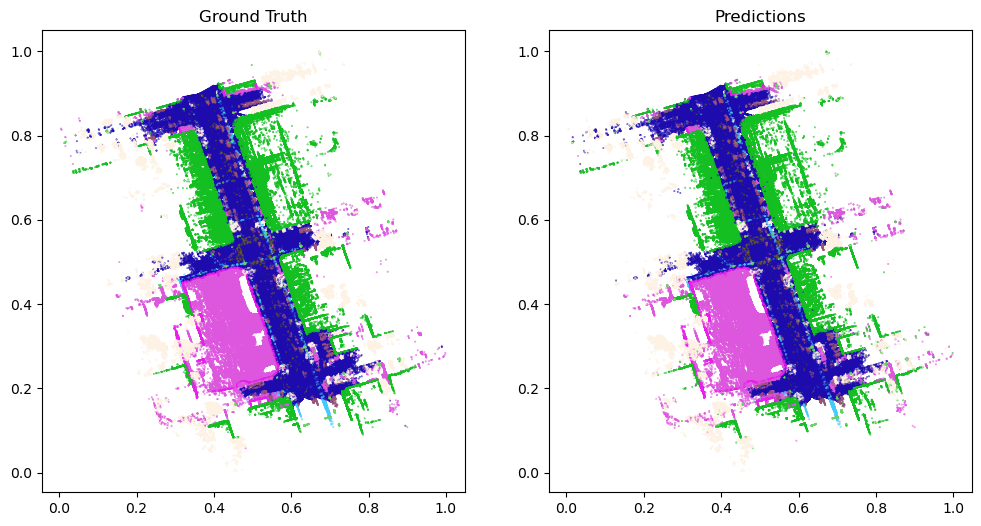

In [13]:
# Scatter plot ground truth
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_colors, s=0.1)
plt.title("Ground Truth")

# Scatter plot predictions
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred_colors, s=0.1)
plt.title("Predictions")

In [16]:
dataset_parma=f"{data_folder}LAS/21/17/Run 172099_20231206_131419_0017_SPATIAL_SUBSAMPLED_2023-12-24_20h52_49_791.las"

In [33]:
las_data = laspy.read(dataset_parma)
points_parma = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()
colors_parma = np.vstack((las_data.red, las_data.green, las_data.blue)).transpose() / 65535.0 # it is a 16 bit value and that is the maximum

features_parma = np.concatenate([points_parma, colors_parma], axis = 1)
features_scaled_parma = scaler.fit_transform(features_parma)

In [34]:
# Make predictions
y_pred_parma = rf_classifier.predict(features_scaled_parma)

In [48]:
# Extract x, y, z from features
xyz = features_parma[:, :3]

# Define a fixed color map for 9 classes
fixed_colors = {
    0: [1.0, 0.0, 0.0],  # Red
    1: [0.0, 1.0, 0.0],  # Green
    2: [0.0, 0.0, 1.0],  # Blue
    3: [1.0, 1.0, 0.0],  # Yellow
    4: [1.0, 0.0, 1.0],  # Magenta
    5: [0.0, 1.0, 1.0],  # Cyan
    6: [0.5, 0.5, 0.5],  # Gray
    7: [1.0, 0.5, 0.0],  # Orange
    8: [0.5, 0.0, 1.0],  # Purple
}

# Map predictions to colors
predicted_colors = np.array([fixed_colors[label] for label in y_pred_parma])

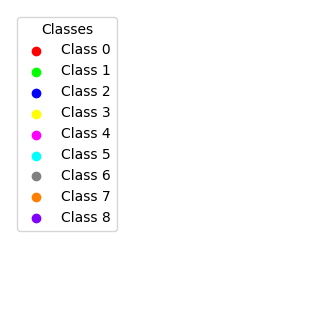

In [49]:
# Create a Matplotlib legend
plt.figure(figsize=(4, 4))
for cls, color in fixed_colors.items():
    plt.scatter([], [], color=color, label=f"Class {cls}")
plt.legend(loc="upper left", title="Classes")
plt.axis("off")
plt.show()

In [50]:
# Create Open3D PointCloud
point_cloud = o3d.geometry.PointCloud()

# Assign points (x, y, z)
point_cloud.points = o3d.utility.Vector3dVector(xyz)

# Assign colors
point_cloud.colors = o3d.utility.Vector3dVector(predicted_colors)

In [51]:
# Visualize
o3d.visualization.draw_geometries([point_cloud])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [69]:
# Create a .las file
output_file = data_folder + "predicted_point_cloud.las"
header = laspy.LasHeader(point_format=3)  # Point format 3 supports RGB
las = laspy.LasData(header)

# Add points
xyz_1 = xyz - [6.02e+05, 4.86e+06, 0]
las.x = xyz_1[:, 0]
las.y = xyz_1[:, 1]
las.z = xyz_1[:, 2]

# Add colors
las.red = predicted_colors[:, 0].astype(np.uint16)
las.green = predicted_colors[:, 1].astype(np.uint16)
las.blue = predicted_colors[:, 2].astype(np.uint16)

# Optionally add classifications if needed
las.classification = y_pred.astype(np.uint8)

# Write to .las
las.write(output_file)